## Linear Regression

Generate linear-looking data with Gaussian noise

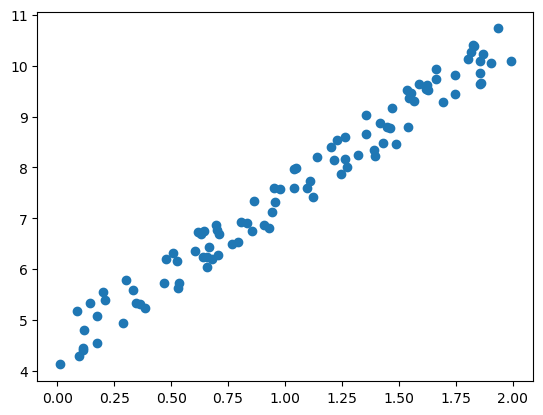

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.rand(100, 1)

plt.scatter(X, y)

Let's compute the value of theta that minimizes the MSE cost function using the <b>Normal Equation</b>

In [2]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print(theta_best)

[[4.39790808]
 [3.08336329]]


In [4]:
X_new = np.array([[0], [2]])

X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.39790808],
       [10.56463466]])

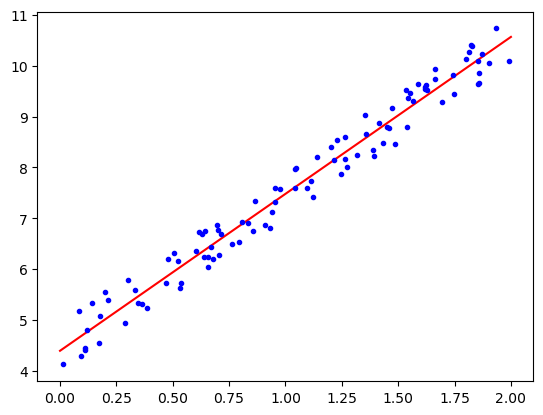

In [5]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.show()

Performing linear regression using Scikit-Learn is quite simple

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.39790808]), array([[3.08336329]]))

In [7]:
lin_reg.predict(X_new)

array([[ 4.39790808],
       [10.56463466]])

The LinearRegression class is based on the scipy.linalg.lstsq() function, which computes the dot product of Moore-Penrose <i>pseudoinverse</i> of X with y to get the optimal theta

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.39790808],
       [3.08336329]])

np.linalg.pinv() can be used to compute the pseudoinverse directly

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[4.39790808],
       [3.08336329]])

The pseudoinverse itself is computed using <b>Singular Value Decomposition</b>

This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely

## Gradient Descent

### Batch Gradient Descent

In [10]:
learning_rate = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iterations in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - learning_rate * gradients
print(theta)

[[4.39790808]
 [3.08336329]]


### Stochastic Gradient Descent

In [11]:
n_epochs = 50
t0, t1 = 5, 50 # Learning schedule hyperparameters

def learning_schedule(t):
    return t0/ (t + t1)

theta = np.random.randn(2, 1) # Random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
print(theta)

[[4.40627412]
 [3.09116703]]


When using Stochastic Gradient Descent, the training instances
must be independent and identically distributed (IID), to ensure
that the parameters get pulled towards the global optimum, on
average.

In [14]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [15]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.37043947]), array([3.10980612]))

### Mini-batch Gradient Descent

Mini-batch GD computes the gradients, on each step, on small random sets of instances called mini-batches. <br>
The main advantage of Mini-batch GD over Stochastic GD is that you can
get a performance boost from hardware optimization of matrix operations, especially
when using GPUs.

## Polynomial Regression

Generate some nonlinear data, based on a simple quadratic equation

In [39]:
m = 100
X = 6 * np.random.randn(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

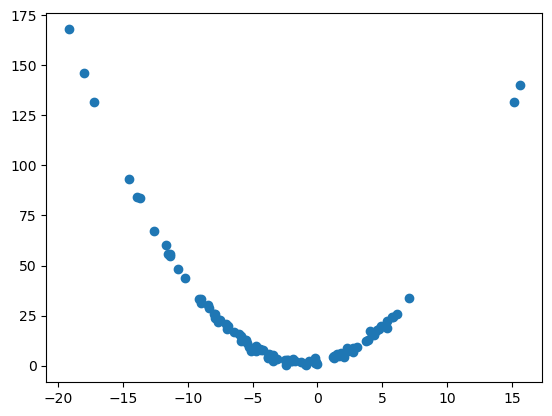

In [40]:
plt.scatter(X, y)

So let’s use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the square (2nd-degree polynomial) of the feature in the training set as new feature

In [42]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(X)
X_poly[0]

array([-8.43071024, 71.07687518])

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.91927816]), array([[1.01089722, 0.50081764]]))

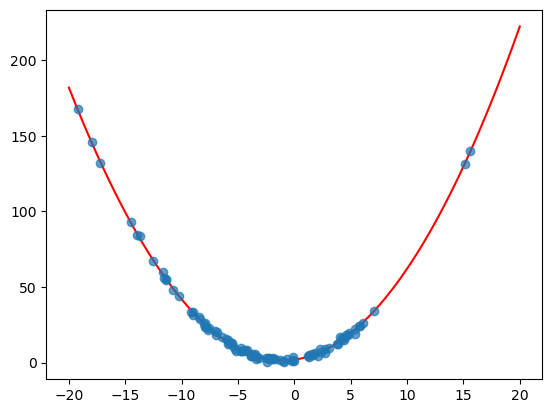

In [62]:
x_predict = np.linspace(-20, 20, 100)
y_predict = lin_reg.coef_[0][1] * x_predict**2 + lin_reg.coef_[0][0]*x_predict + lin_reg.intercept_

plt.plot(x_predict, y_predict, c='red', zorder=0)
plt.scatter(X, y, alpha=0.7)
plt.show()

## Learning Curves

In [73]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend()
    plt.ylabel('RMSE')
    plt.xlabel('Training set size')
    plt.show()

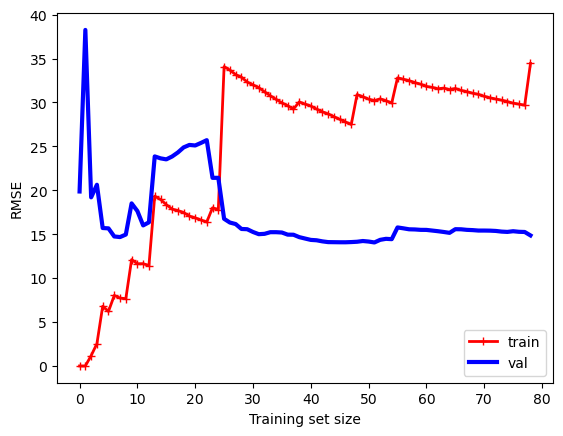

In [74]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

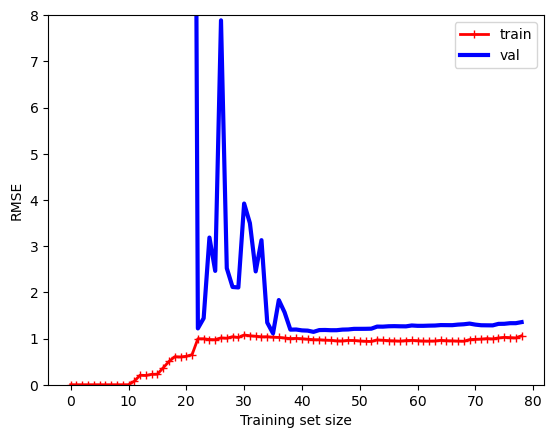

In [82]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
    ])

plt.ylim(0, 8)
plot_learning_curves(polynomial_regression, X, y)